In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
sns.set_style({'font.family':'sans-serif'})
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

# Parse Job Completion Times

In [2]:
import ast
import os
import re
def parse_directory(directory_name):
    directory = os.fsencode(directory_name)
    policy_names = []
    all_job_completion_times = []
    all_events = []
    print("Total time taken")
    for file_name in ["fifo.out", "ks.out", "ks_packed.out",
                      "max_throughput.out", "isolated.out"]:
        policy_name = file_name.replace(".out", "")
        job_completion_times = None
        total_time_taken = None
        events = {}
        with open(os.path.join(directory_name, file_name), 'r') as f:
            parse_next_line = False
            for line in f:
                if parse_next_line:
                    line = line.strip()
                    job_completion_times = ast.literal_eval(line)
                    parse_next_line = False
                if line.strip() == "Job completion times:":
                    parse_next_line = True
                regex = r'\[Job ID: (\d+), Worker ID: (\d+) \[(.*)\]\] Start: (\d+), End: (\d+)'
                m = re.match(regex, line.strip())
                if m is not None:
                    job_id = int(m.group(1))
                    worker_id = int(m.group(2))
                    worker_type = m.group(3)
                    start = int(m.group(4))
                    end = int(m.group(5))
                    if worker_id not in events:
                        events[worker_id] = []
                    events[worker_id].append((job_id, worker_type, start, end))
                regex = r'Total time taken: (\d+\.\d+) timeunits'
                m = re.match(regex, line.strip())
                if m is not None:
                    total_time_taken = float(m.group(1))
            if total_time_taken is not None:
                print("%s: %.2f timeunits" % (policy_name, total_time_taken))
        if job_completion_times is not None:
            policy_names.append(policy_name)
            all_job_completion_times.append(list(job_completion_times.values()))
            all_events.append(events)
    return all_job_completion_times, all_events, policy_names

# Plot Job Completion Time CDFs

In [3]:
def plot_jct_cdf(all_job_completion_times, policy_names,
                 labels=None, threshold_type=None):
    plt.figure(figsize=(10, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    print("Average job completion times")
    for (job_completion_times, policy_name) in zip(
        all_job_completion_times, policy_names):
        durations = [x[1] for x in job_completion_times]
        threshold_duration = sorted(durations)[int(0.7 * len(durations))]

        if threshold_type is None:
            job_completion_times = [x[0] for x in job_completion_times]
        elif threshold_type == 'lower':
            job_completion_times = [x[0] for x in job_completion_times
                                    if x[1] <= threshold_duration]
        elif threshold_type == 'higher':
            job_completion_times = [x[0] for x in job_completion_times
                                    if x[1] > threshold_duration]
        if labels is not None:
            if policy_name not in labels:
                continue
        job_completion_times.sort()
        print("%s: %.4f" % (policy_name,
                            sum(job_completion_times) / len(job_completion_times)))
        cumulative_job_completion_times = [0.0]
        for x in job_completion_times:
            cumulative_job_completion_times.append(x)
        cumulative_percentages = [((i+1) * 100.0) / (len(cumulative_job_completion_times)+1)
                                  for i in range(len(cumulative_job_completion_times))]

        label = policy_name.replace("_", "\_")
        if labels is not None:
            label = labels[policy_name]
        ax.plot([0] + job_completion_times,
                cumulative_percentages, label=label)

    ax.set_xlabel("Job Completion Time")
    ax.set_ylabel("CDF (\%)")
    ax.set_xlim([0, None])
    ax.set_ylim([0, 100])
    
    plt.legend(loc='best')
    plt.show()

Total time taken
fifo: 2802580.30 timeunits
ks: 2323882.04 timeunits
ks_packed: 1994560.23 timeunits
max_throughput: 2475531.34 timeunits
isolated: 3059928.31 timeunits
Average job completion times
fifo: 1084670.0407
ks: 934509.6196
ks_packed: 746219.3676
max_throughput: 1144420.5625
isolated: 1377702.0791


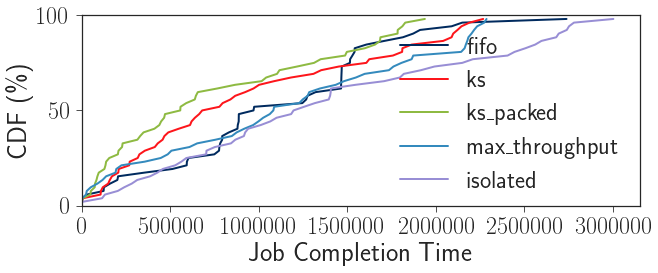

Average job completion times
fifo: 994643.4681
ks: 554311.6594
ks_packed: 407948.4553
max_throughput: 1058766.7737
isolated: 927158.9619


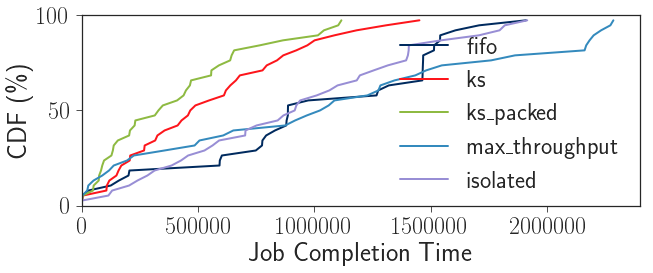

Average job completion times
fifo: 1316166.9416
ks: 1912161.5175
ks_packed: 1616058.8563
max_throughput: 1364673.1622
isolated: 2536241.5234


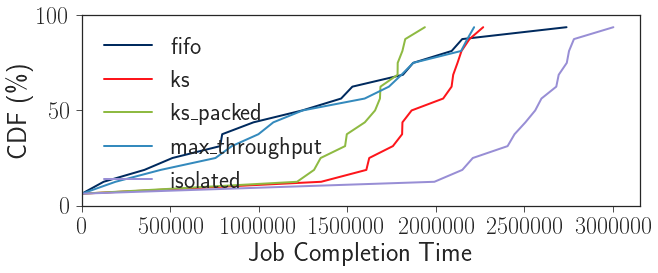

In [4]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long/")
plot_jct_cdf(all_job_completion_times, policy_names, threshold_type=None)
plot_jct_cdf(all_job_completion_times, policy_names, threshold_type='lower')
plot_jct_cdf(all_job_completion_times, policy_names, threshold_type='higher')

Total time taken
fifo: 2802580.30 timeunits
ks: 2323882.04 timeunits
ks_packed: 1994560.23 timeunits
max_throughput: 2475531.34 timeunits
isolated: 3059928.31 timeunits
Average job completion times
ks: 934509.6196
isolated: 1377702.0791


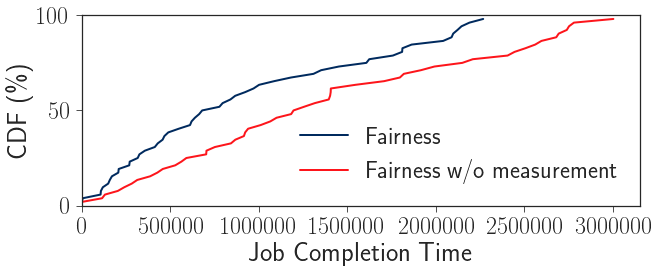

Average job completion times
ks: 554311.6594
isolated: 927158.9619


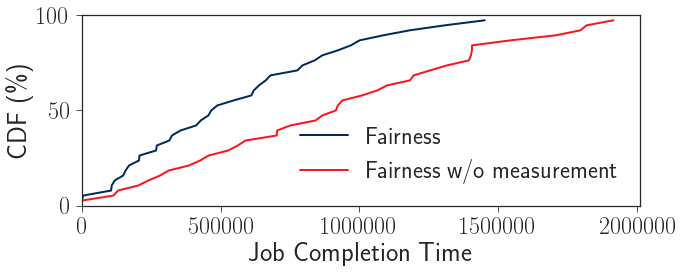

Average job completion times
ks: 1912161.5175
isolated: 2536241.5234


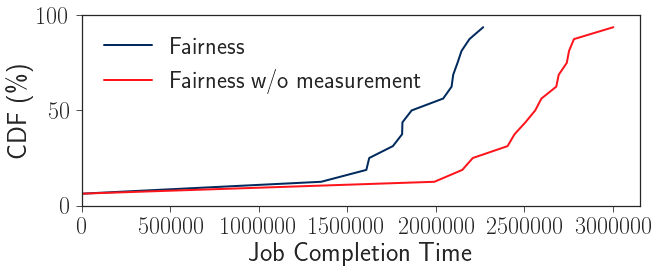

In [5]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long/")
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "isolated": "Fairness w/o measurement"},
             threshold_type=None)
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "isolated": "Fairness w/o measurement"},
             threshold_type='lower')
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "isolated": "Fairness w/o measurement"},
             threshold_type='higher')

Total time taken
fifo: 2802580.30 timeunits
ks: 2323882.04 timeunits
ks_packed: 1994560.23 timeunits
max_throughput: 2475531.34 timeunits
isolated: 3059928.31 timeunits
Average job completion times
fifo: 1084670.0407


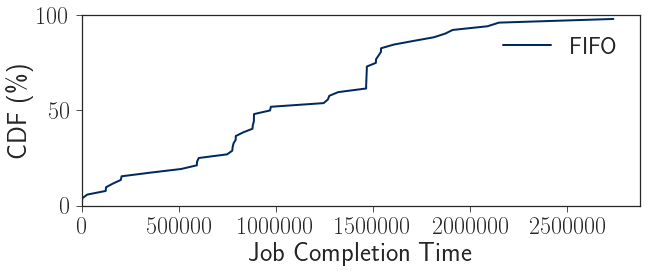

Average job completion times
fifo: 1084670.0407
ks: 934509.6196


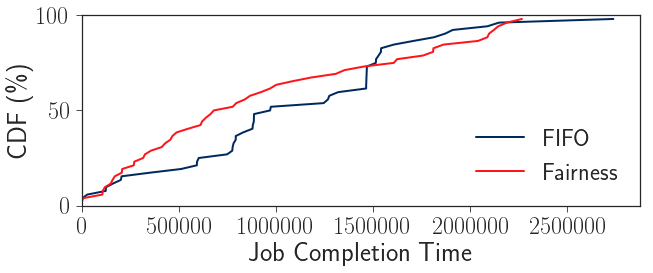

Average job completion times
fifo: 1084670.0407
ks: 934509.6196
ks_packed: 746219.3676


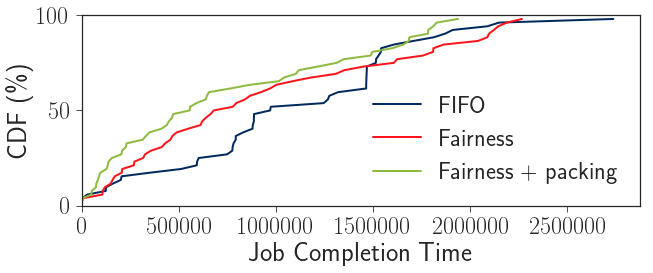

Average job completion times
fifo: 994643.4681
ks: 554311.6594
ks_packed: 407948.4553


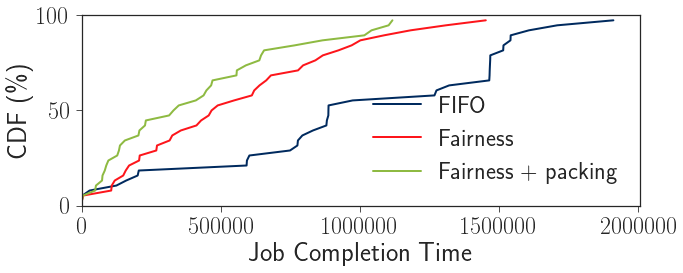

Average job completion times
fifo: 1316166.9416
ks: 1912161.5175
ks_packed: 1616058.8563


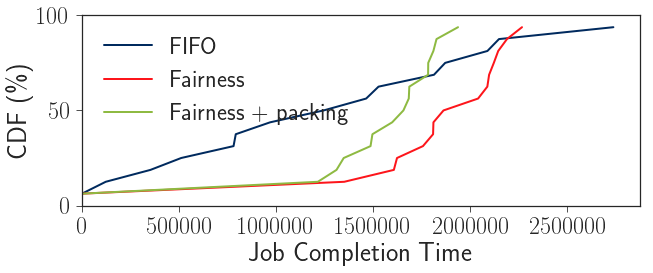

In [15]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long/")
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"fifo": "FIFO"},
             threshold_type=None)
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"fifo": "FIFO", "ks": "Fairness"},
             threshold_type=None)
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks_packed": "Fairness + packing", "ks": "Fairness", "fifo": "FIFO"},
             threshold_type=None)

plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks_packed": "Fairness + packing", "ks": "Fairness", "fifo": "FIFO"},
             threshold_type='lower')
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks_packed": "Fairness + packing", "ks": "Fairness", "fifo": "FIFO"},
             threshold_type='higher')

Total time taken
fifo: 1440394.85 timeunits
ks: 1577382.66 timeunits
ks_packed: 1524748.74 timeunits
max_throughput: 1803202.74 timeunits
isolated: 2066308.30 timeunits
Average job completion times
fifo: 383037.4810
ks: 422499.3890
ks_packed: 398556.1923
max_throughput: 650840.0652
isolated: 769928.7391


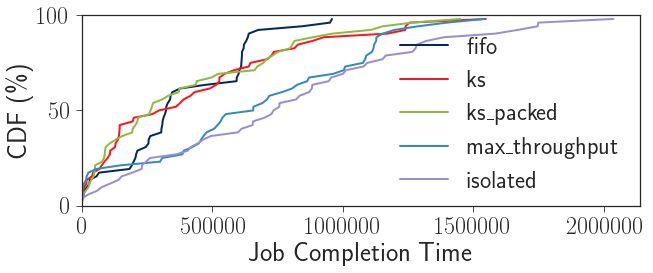

In [7]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long_low_load/")
plot_jct_cdf(all_job_completion_times, policy_names)

Total time taken
fifo: 1982700.32 timeunits
ks: 1939064.91 timeunits
ks_packed: 2010909.92 timeunits
max_throughput: 2068369.06 timeunits
isolated: 2490049.58 timeunits
Average job completion times
fifo: 155976.7035
ks: 130018.1589
ks_packed: 146255.3791
max_throughput: 172859.1187
isolated: 266343.5832


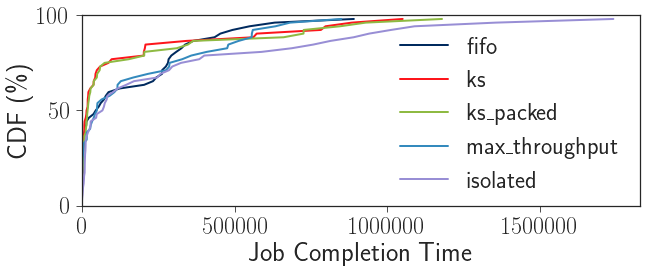

In [8]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long_really_low_load/")
plot_jct_cdf(all_job_completion_times, policy_names)

Total time taken
fifo: 1982700.32 timeunits
ks: 1939064.91 timeunits
ks_packed: 2010909.92 timeunits
max_throughput: 2068369.06 timeunits
isolated: 2490049.58 timeunits
Average job completion times
ks: 130018.1589
isolated: 266343.5832


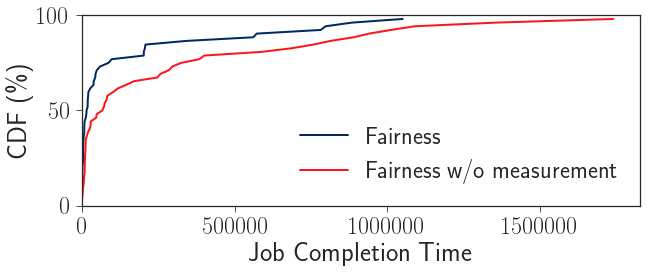

Average job completion times
ks: 18592.9189
isolated: 81853.9894


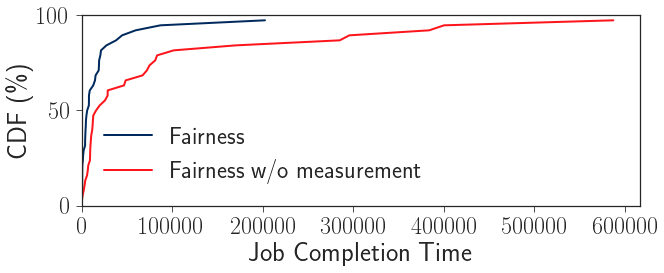

Average job completion times
ks: 416540.2047
isolated: 740745.3957


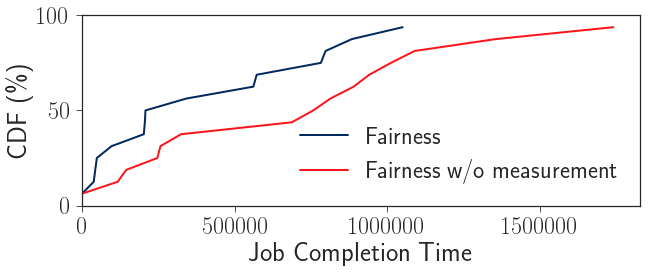

In [9]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long_really_low_load/")
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "isolated": "Fairness w/o measurement"},
             threshold_type=None)
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "isolated": "Fairness w/o measurement"},
             threshold_type='lower')
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "isolated": "Fairness w/o measurement"},
             threshold_type='higher')        

Total time taken
fifo: 1982700.32 timeunits
ks: 1939064.91 timeunits
ks_packed: 2010909.92 timeunits
max_throughput: 2068369.06 timeunits
isolated: 2490049.58 timeunits
Average job completion times
fifo: 155976.7035
ks: 130018.1589


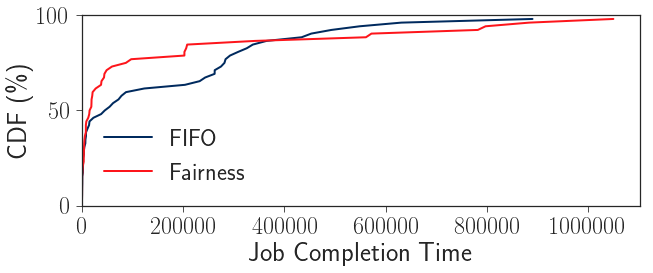

Average job completion times
fifo: 70884.0909
ks: 18592.9189


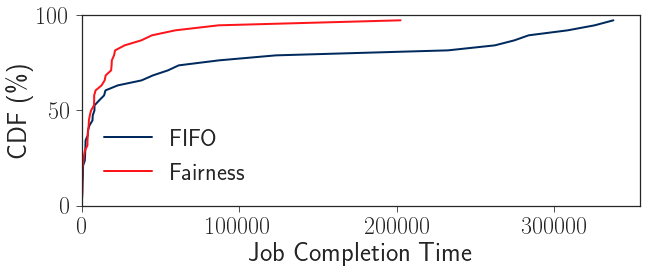

Average job completion times
fifo: 374786.2788
ks: 416540.2047


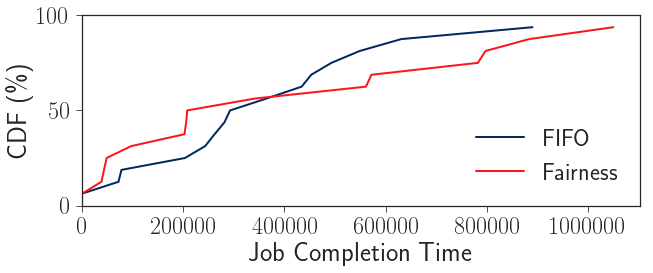

In [10]:
all_job_completion_times, _, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long_really_low_load/")
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "fifo": "FIFO"},
             threshold_type=None)
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "fifo": "FIFO"},
             threshold_type="lower")
plot_jct_cdf(all_job_completion_times, policy_names,
             labels={"ks": "Fairness", "fifo": "FIFO"},
             threshold_type="higher")

# Plot event timeline

In [11]:
def plot_events(all_events, policy_names, xstart=None, xend=None):
    for (events, policy_name) in zip(all_events, policy_names):
        print("Policy name: %s" % policy_name)
        
        plt.figure(figsize=(20, 3.5))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

        max_worker_id = None
        max_end = None
        worker_id_to_type_mapping = {}
        for worker_id in events:
            if max_worker_id is None or worker_id > max_worker_id:
                max_worker_id = worker_id
            for (job_id, worker_type, start, end) in events[worker_id]:
                if max_end is None or end > max_end:
                    max_end = end
                if worker_id not in worker_id_to_type_mapping:
                    worker_id_to_type_mapping[worker_id] = worker_type
                ax.plot([start, end], [worker_id, worker_id],
                        linewidth=10, c="C%d" % (job_id % 10))

        ax.set_xlabel("Time")
        ax.set_ylabel("Worker ID")
        if max_end is not None:
            if xstart is None:
                xstart = 0
            if xend is None:
                xend = (max_end + 1)
            ax.set_xlim([xstart, xend])
        if max_worker_id is not None:
            print(worker_id_to_type_mapping)
            ax.set_ylim([-0.5, max_worker_id+0.5])

        plt.legend()
        plt.show()

Total time taken
fifo: 2802580.30 timeunits
ks: 2323882.04 timeunits
ks_packed: 1994560.23 timeunits
max_throughput: 2475531.34 timeunits
isolated: 3059928.31 timeunits
Policy name: fifo


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


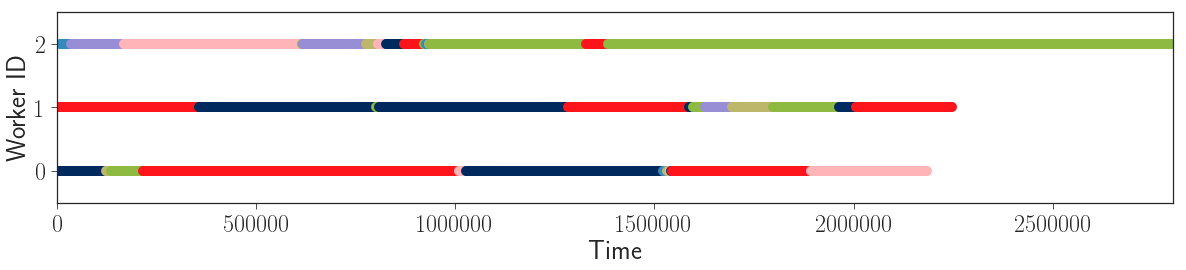

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 2: 'k80', 1: 'p100'}


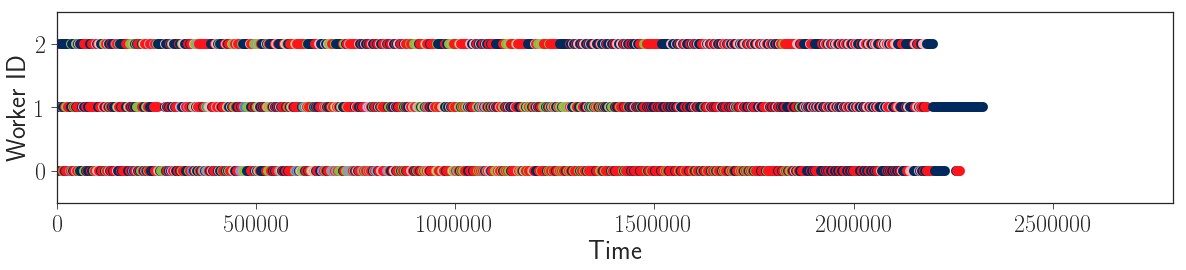

Policy name: ks_packed


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


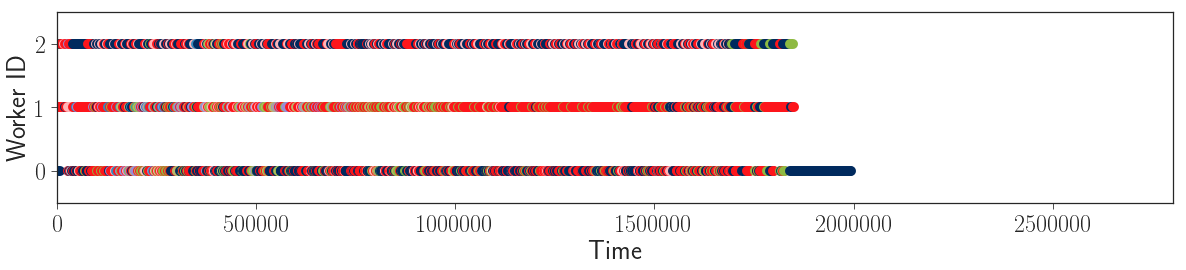

Policy name: max_throughput


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


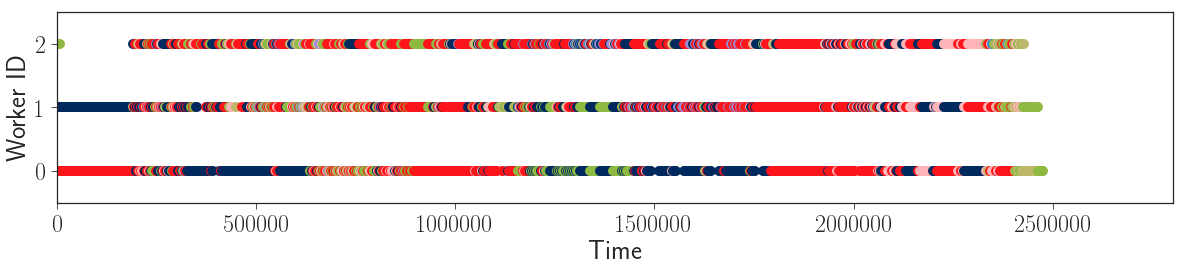

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


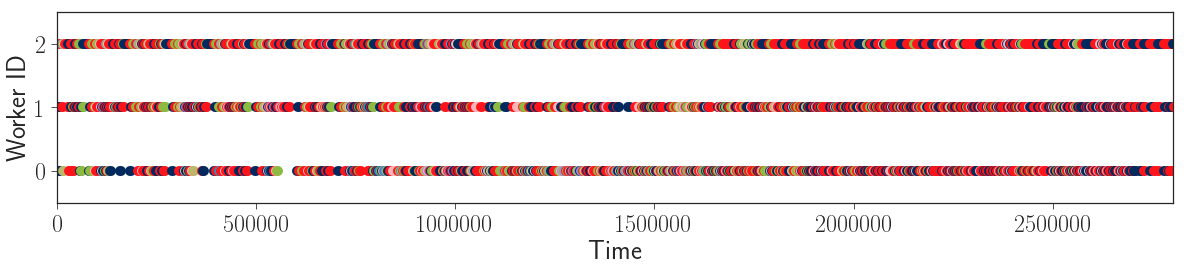

In [12]:
_, all_events, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long/")
plot_events(all_events, policy_names)

Total time taken
fifo: 1440394.85 timeunits
ks: 1577382.66 timeunits
ks_packed: 1524748.74 timeunits
max_throughput: 1803202.74 timeunits
isolated: 2066308.30 timeunits
Policy name: fifo


No handles with labels found to put in legend.


{1: 'p100', 2: 'k80', 0: 'v100'}


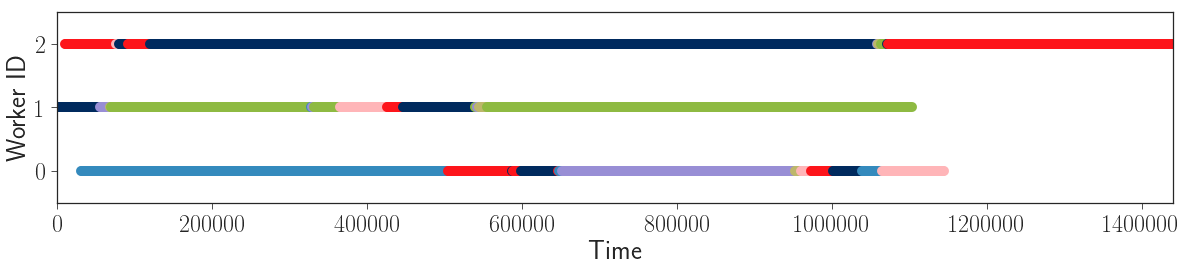

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


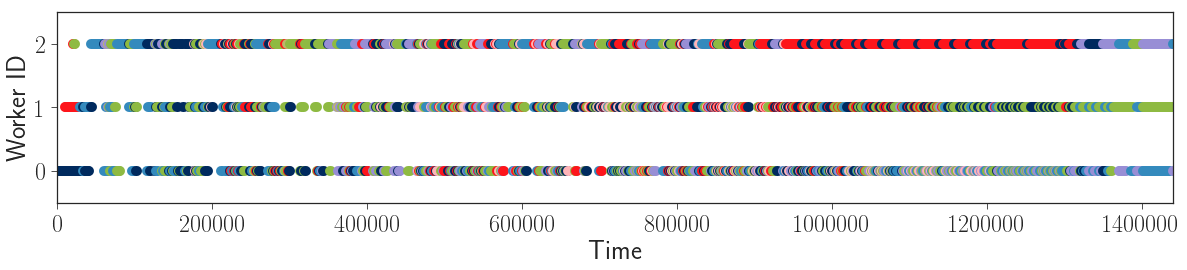

Policy name: ks_packed


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


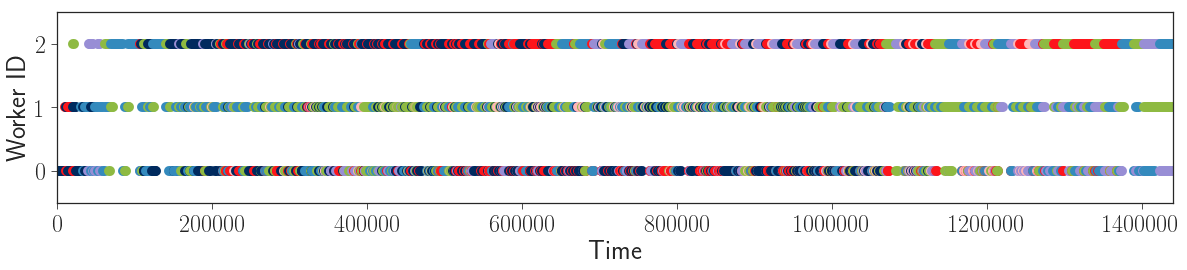

Policy name: max_throughput


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


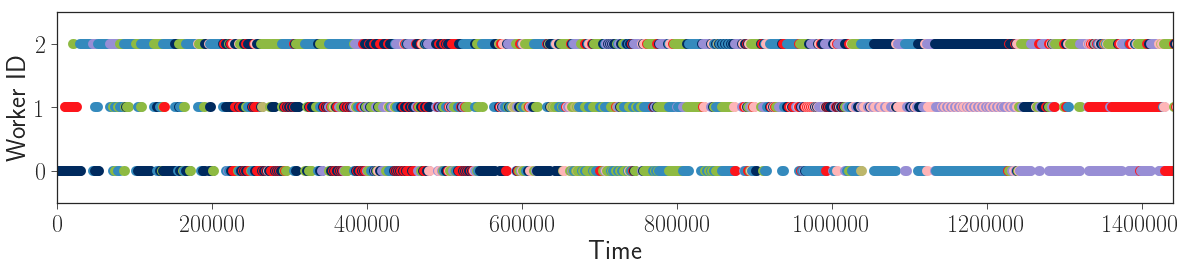

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


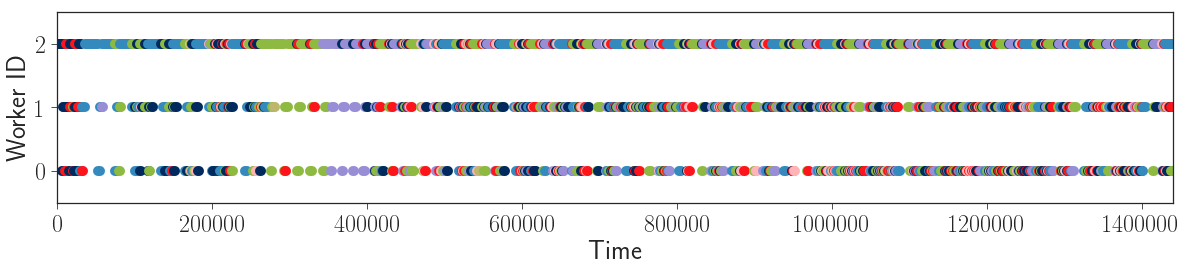

In [13]:
_, all_events, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long_low_load/")
plot_events(all_events, policy_names)

Total time taken
fifo: 1982700.32 timeunits
ks: 1939064.91 timeunits
ks_packed: 2010909.92 timeunits
max_throughput: 2068369.06 timeunits
isolated: 2490049.58 timeunits
Policy name: fifo


No handles with labels found to put in legend.


{2: 'k80', 1: 'p100', 0: 'v100'}


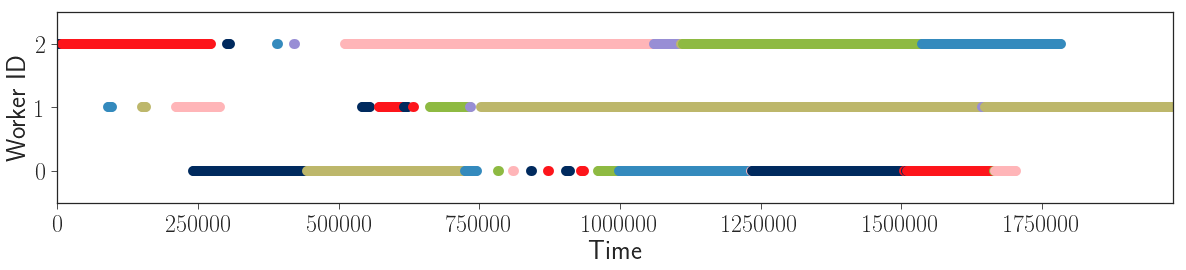

Policy name: ks


No handles with labels found to put in legend.


{0: 'v100', 2: 'k80', 1: 'p100'}


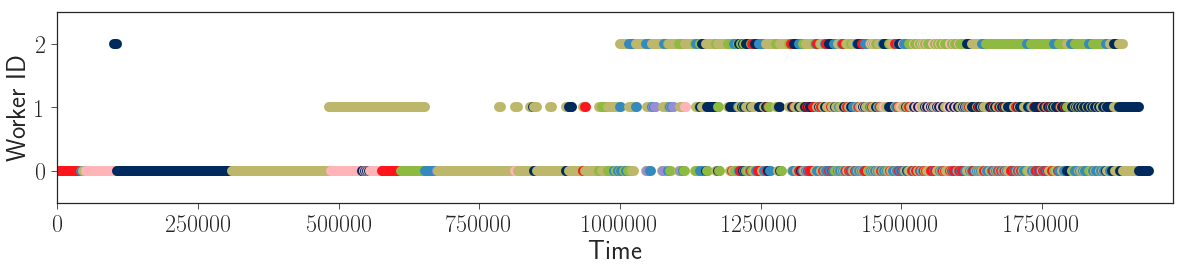

Policy name: ks_packed


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


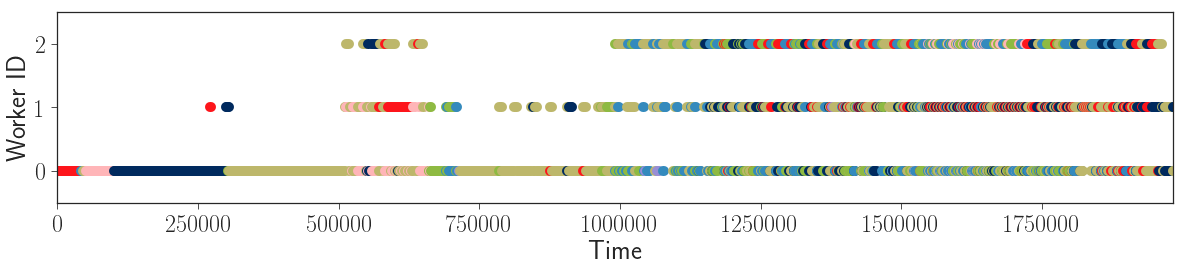

Policy name: max_throughput


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


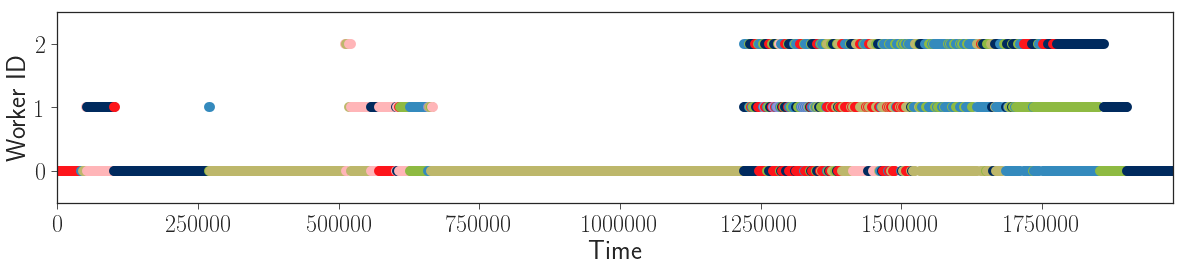

Policy name: isolated


No handles with labels found to put in legend.


{0: 'v100', 1: 'p100', 2: 'k80'}


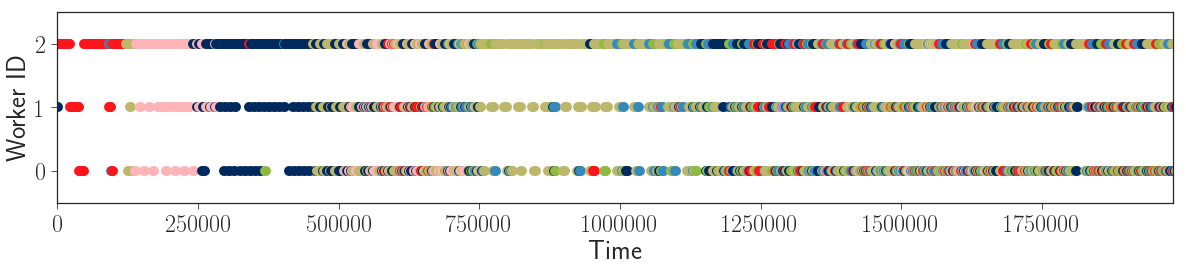

In [14]:
_, all_events, policy_names = parse_directory(
    "../logs/poisson_lam=2000_real_job_duration_dist_long_really_low_load/")
plot_events(all_events, policy_names)